In [207]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize
from copy import deepcopy
import time


class Constraint():
    """Constraints loaded from a file."""

    def __init__(self, fname):
        """
        Construct a Constraint object from a constraints file

        :param fname: Name of the file to read the Constraint from (string)
        """
        with open(fname, "r") as f:
            lines = f.readlines()
        # Parse the dimension from the first line
        self.n_dim = int(lines[0])
        # Parse the example from the second line
        self.example = [float(x) for x in lines[1].split(" ")[0:self.n_dim]]

        # Run through the rest of the lines and compile the constraints
        self.exprs = []
        for i in range(2, len(lines)):
            # support comments in the first line
            if lines[i][0] == "#":
                continue
            self.exprs.append(compile(lines[i], "<string>", "eval"))
        
        # see the related functions for the variable meaning
        [self.var_constrs, id_vars, self.related_vars] = self.get_var_constraints(lines)
        self.var_groups = self.get_var_groups(id_vars)
        self.bounds = self.get_bounds()
        self.exprs_batch = self.make_exprs_batch(lines)
        
        return

    def get_example(self):
        """Get the example feasible vector"""
        return self.example

    def get_ndim(self):
        """Get the dimension of the space on which the constraints are defined"""
        return self.n_dim

    def apply(self, x):
        """
        Apply the constraints to a vector, returning True only if all are satisfied

        :param x: list or array on which to evaluate the constraints
        """
        for expr in self.exprs:
            if not eval(expr):
                return False
        return True   
    
    def make_exprs_batch(self, lines):
        """
        Apply the constraints to a matrix = [n, n_dim], returning Goodness of the data.

        :param  x: matrix on which to evaluate the constraints
                goodness: array of size [n, ]. Each element determines the goodness of the data points
        """
        exprs_batch = []
        for i in range(2, len(lines)):
            if lines[i][0] == "#":
                continue
            expr = lines[i]
            idx = 0
            while True:
                idx_tmp = expr[idx:].find('[')
                if idx_tmp == -1: break
                idx += idx_tmp + 1
                expr = expr[:idx] + ':,' + expr[idx:]
                idx += 2
            exprs_batch.append(compile(expr, "<string>", "eval"))
        return exprs_batch

    def apply_batch(self, x): 
        """
        Apply the constraints to a matrix = [n, n_dim], returning Goodness of the data.

        :param  x: matrix on which to evaluate the constraints
                x_good: the good samples that satisfy all constraints
        """
        n_sample = x.shape[0]
        mask_gooddata = np.zeros([n_sample, len(self.exprs_batch)])
        for i in range(len(self.exprs_batch)):
            mask_gooddata[:,i] = eval(self.exprs_batch[i])
        idx = np.arange(n_sample)
        mask_gooddata = np.all(mask_gooddata, 1)
        idx = idx[mask_gooddata]  
        x_good = x[idx, :]
        return x_good
    
    def get_var_constraints(self, lines):
        """
        Re-organize the constraints into a list var_constrs = [n_dim, 2], and its related variables 
        
        :param  vars_inline = [num_constr, ], num_constr is the number of constraints. 
                    vars_inline [j]: the variables evaluated in constraint_j. Will be used in self.get_var_groups()
                var_constrs = [n_dim, 2, None], [i, 1, :] contain the linear constraints in which x_i have appeared
                    [i, 2, :] contains the non-linear constraints.
                related_vars = [n_dim, 2, None], same structure as var_constrs, records not the contraint expression but
                    the varibles that have appeared in var_constrs[i, k, l]. 
                    Will be used in get_bounds() and update_current_bounds().
        """
        vars_inline = []
        id_vars = []

        idx_exprs = 0
        for i in range(2, len(lines)):
                # support comments in the first line
                if lines[i][0] == "#":
                    continue
                # record variables involved in this constraint
                id_vars_tmp = []
                for pos, char in enumerate(lines[i]):
                    if char == '[':
                        interval = lines[i][pos:].find(']')
                        id_vars_tmp.append(int(lines[i][pos+1 : pos+interval]))
                vars_inline.append(i)
                # append unique variable ids only
                id_vars.append(list(set(id_vars_tmp)))

        # re-organize the constraints according to the envolved variables
        var_constrs = []
        related_vars = []
        for i in range(self.n_dim):
            var_constrs.append([[], []])
            related_vars.append([[], []])
            
        for i in range(len(vars_inline)):
            idx_linearity = 0
            # check if the constraint is linear
            if any(operator in lines[vars_inline[i]] for operator in ['*', '/', '**']):
                idx_linearity = 1
            # append a contraint to every involved variable
            for j in range(len(id_vars[i])):
                var_constrs[id_vars[i][j]][idx_linearity].append(lines[vars_inline[i]])
                related_vars[id_vars[i][j]][idx_linearity].append(id_vars[i])
        return var_constrs, id_vars, related_vars

    def get_bounds(self):
        """
        Get variable bounds from linear constraints of this variable.
        Assumption: in the purely linear constraints, every x_i will apprear only once.
        
        :param  bounds_current = [n_dim, 2], low and high bounds of the variables. 
        """
        bounds = np.zeros([self.n_dim, 2])
        bounds[:,1] = 1.0
        for i in range(self.n_dim):
            # if no linear constraint available, skip 
            if len(self.var_constrs[i][0]) == 0:
                continue
            # loop linear constraints of x_i
            for j in range(len(self.var_constrs[i][0])):
                expr = self.var_constrs[i][0][j]
                expr_vars = self.related_vars[i][0][j]
                # if x_i is the only variable in current linear constraint, then bounds[i,:] can be updated
                if len(expr_vars) == 1:
                    expr = self.var_constrs[i][0][j]
                    # remove the logical part: >= 0
                    idx_expr = find_char_pos(expr, '>')
                    expr = expr[0:idx_expr]
                    # get the sign of x 
                    idx_x = find_char_pos(expr, 'x')
                    if idx_x == 0:
                        x_sign = '+'
                    else:
                        x_sign = expr[idx_x-2]
                    # evaluate the expression to get bounds
                    x = np.zeros(self.n_dim)
                    tmp = eval(compile(expr, "<string>", "eval"))
                    if x_sign == '+':
                        if tmp < 0:
                            bounds[i,0] = - tmp
                        else:
                            bounds[i,1] = 1.0 - tmp
                    else:
                        if tmp > 0:
                            bounds[i,1] = tmp
                        else:
                            print '!!! intrinsic linear bounds evaluation problem !!!'
        return bounds
        
def find_char_pos(s, ch):
    """
    auxiliary function for finding character position

    :param  s, string
            ch, character
    """  
    if len(s) == 1:
        idxes = [i for i, letter in enumerate(s) if letter == ch]
    else:
        idxes = [s.find(ch)]
    if len(idxes) == 1:
        idxes = idxes[0]
    return idxes


In [208]:
start_time = time.time()
constraint = Constraint('./Examples/alloy.txt')
bounds = constraint.bounds
num_sample = 1e6

go_on = True
x_good_list = np.zeros([1, constraint.n_dim])
while go_on:
    x = np.zeros([int(num_sample), constraint.n_dim])
    for i in range(constraint.n_dim):
        x[:,i] = np.random.uniform(bounds[i,0], bounds[i,1], (int(num_sample),))
    x_good = constraint.apply_batch(x)
    x_good_list = np.vstack([x_good_list, x_good])
    go_on = (x_good_list.shape[0] < 1001)
x_good_list = x_good_list[1:1001, :]

np.savetxt('result.txt', x_list, delimiter=' ', fmt='%1.6f')

print x_good_list.shape
print("--- %s seconds ---" % (time.time() - start_time))




# print id_vars
# var_consts

AttributeError: Constraint instance has no attribute 'get_var_groups'

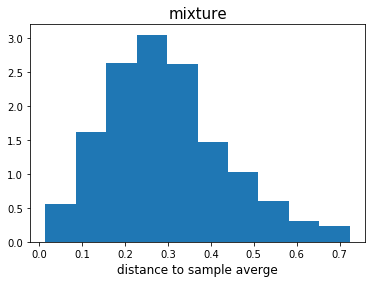

In [204]:
import matplotlib.pyplot as plt
for i in range(len(x_good_list)):
    if not constraint.apply(x_good_list[i,:]):
        print 'bad data'
        break
x_ave = np.sum(x_good_list, axis=0)/x_good_list.shape[0]
dist = np.linalg.norm(x_good_list - x_ave, axis=1)

# np.std(x_good_list, axis=1)
name = 'mixture'
plt.hist(dist, density=True)
plt.xlabel('distance to sample averge', fontsize=12)
plt.title(name, fontsize=15)
plt.show
plt.savefig(name, dpi=300)
# x_good_list.shape

(1000,)